In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
"""Importing the 'private and public spending on construction in the United States from 2002 through 2013 
with partial data for 2014' (data source: US Census Bureau)"""

df_cons = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
df_cons

,Month,Month-Year,TotalConstruction,PrivateConstruction,PublicConstruction
0,1,2-Jan,59516,45273,14243
1,2,2-Feb,58588,44475,14113
2,3,2-Mar,63782,49396,14386
3,4,2-Apr,69504,53283,16221
4,5,2-May,73384,55009,18375
...,...,...,...,...,...
141,142,13-Oct,85193,59370,25823
142,143,13-Nov,77931,55191,22741
143,144,13-Dec,71502,52132,19369
144,145,14-Jan,64661,47827,16834


# Private spending on construction (time series decomposition)

In [3]:
"""Creating a new data frame, 'df_private' to extract private construction data only."""

df_private = df_cons[['Month', 'Month-Year', 'PrivateConstruction']].copy()
df_private

,Month,Month-Year,PrivateConstruction
0,1,2-Jan,45273
1,2,2-Feb,44475
2,3,2-Mar,49396
3,4,2-Apr,53283
4,5,2-May,55009
...,...,...,...
141,142,13-Oct,59370
142,143,13-Nov,55191
143,144,13-Dec,52132
144,145,14-Jan,47827


Based on the initial visualization of the private construction data seen below, the trend of the data appears to be nonlinear.

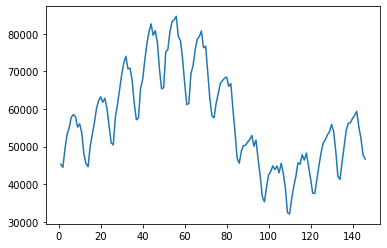

In [4]:
plt.plot(df_private.Month, df_private.PrivateConstruction)

#### A moving average was used to calculate the 'trend' component of the model. Window sizes of 2, 4, 6, 8, and 10 months resulted in a lower average of squared errors, followed by 28 months. 28 months was chosen so that cyclicality could account for the rest of the residual data.

Average Squared Error per Month:  27906328.62513241
Cumulative Squared Error:  3292946777.7656245


C:\Users\ajten\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,Month,Month-Year,PrivateConstruction,MovAvg,sqErr
2003-03-31,15,3-Mar,49996,55003.142857,2.507148e+07
2003-04-30,16,3-Apr,53195,55794.535714,6.757586e+06
2003-05-31,17,3-May,56286,56639.857143,1.252149e+05
2003-06-30,18,3-Jun,60076,57416.500000,7.072940e+06
2003-07-31,19,3-Jul,62216,58065.982143,1.722265e+07
...,...,...,...,...,...
2012-08-31,128,12-Aug,53073,48793.000000,1.831840e+07
2012-09-30,129,12-Sep,53874,49214.732143,2.170878e+07
2012-10-31,130,12-Oct,55888,49469.339286,4.119921e+07
2012-11-30,131,12-Nov,53942,49572.375000,1.909362e+07


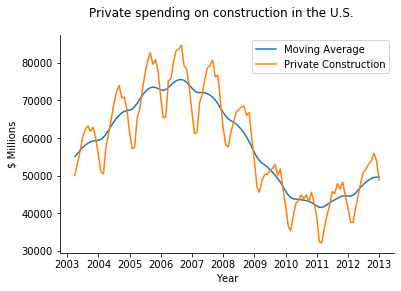

In [5]:
def sqErr(row):
    return (row['PrivateConstruction'] - row['MovAvg'])**2

df_private['MovAvg'] = np.NaN
df_private['sqErr'] = np.NaN

# Converts the index of the data frame to a 'time' format
df_private.index = pd.date_range(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_private['PrivateConstruction']))

window = 28
window = window - window % 2

# Loop below computes the moving average centered on each of the data points
for i in range(int(window/2),df_private.shape[0]-int(window/2)):
    df_private.loc[df_private.index[i],'MovAvg'] = (0.5*df_private.iloc[i - int(window/2)]['PrivateConstruction'] + df_private.iloc[i - int(window/2)+1:i + int(window/2)]['PrivateConstruction'].sum() + 0.5*df_private.iloc[i + int(window/2)]['PrivateConstruction'])/float(window)

# Calculation of the 'square error' for each data point
df_private['sqErr'] = (df_private['PrivateConstruction'] - df_private['MovAvg'])**2

# Drops the rows that cannot be used in the data set (based on the window size)
df_private.dropna(how='any', inplace=True)

# Plots the private construction data with the calculated moving average overlayed
fig,ax = plt.subplots()
ax.plot(df_private['MovAvg'], label='Moving Average')
ax.plot(df_private['PrivateConstruction'], label='Private Construction')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle('Private spending on construction in the U.S.')
ax.legend()
print('Average Squared Error per Month: ',sum(df_private['sqErr'])/len(df_private))
print('Cumulative Squared Error: ', sum(df_private['sqErr']))
df_private

Average Residual:  165.43719733656152


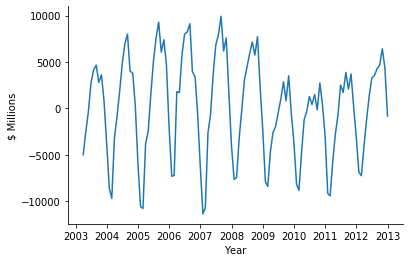

In [6]:
"""Calculating and plotting the residuals, 'R1'."""

df_private['R1'] = df_private['PrivateConstruction'] - df_private['MovAvg']
df_private['R1Error'] = abs((df_private['PrivateConstruction'] - df_private['R1'])/df_private['PrivateConstruction'])
df_private.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

fig,ax = plt.subplots()
ax.plot(df_private['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_private['R1'])/len(df_private))

In [7]:
"""Calculating the autocorrelation from the residual data to determine whether any cyclical patterns exist."""

maxCorr = 0.0
period = np.NaN
for i in range(1,21):
    corr = df_private['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.802817791693665
Correlation, lag  2     0.4443534589868593
Correlation, lag  3     0.020476842888635695
Correlation, lag  4     -0.3395526458258491
Correlation, lag  5     -0.5946355941654637
Correlation, lag  6     -0.7256392985138465
Correlation, lag  7     -0.626869741908392
Correlation, lag  8     -0.396315840672076
Correlation, lag  9     -0.0552300506808024
Correlation, lag  10     0.350135855726644
Correlation, lag  11     0.6979125314418182
Correlation, lag  12     0.8927182172333037
Correlation, lag  13     0.7167085973043467
Correlation, lag  14     0.38251474913428596
Correlation, lag  15     -0.01931861069919423
Correlation, lag  16     -0.36054942226148884
Correlation, lag  17     -0.598581299411287
Correlation, lag  18     -0.7205781836890767
Correlation, lag  19     -0.6202726789012772
Correlation, lag  20     -0.404890237189766
period =  12      Maximum Correlation =  0.8927182172333037


#### A period of 12 is the maximium correlation, suggesting that the cyclicality component is for 12 months or one year. The graph below plots the data in 12 month inverals, and the red line is the average of all the cycles.

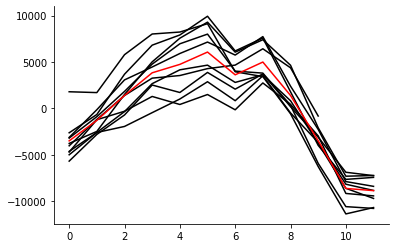

In [8]:
period = 12
cycleLen = period
numCycles = int(len(df_private)/cycleLen + 0.5)
cycles = [df_private.iloc[range(i*period,min((i+1)*period,len(df_private)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df_private.iloc[range(i,len(df_private['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values, label='Cycle '+ str(i), c='k')
ax.plot(avg, label='Average Cycle', c='r')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### The cyclicality component is calculated and plotted against the residual data to visualize how close of a fit it is.

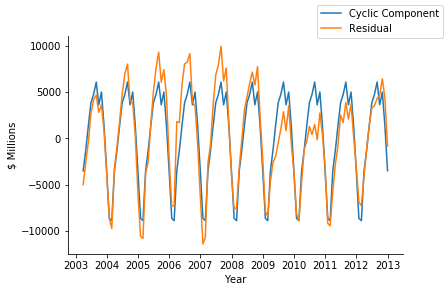

In [9]:
cycleLen = period 
numCycles = int(len(df_private)/cycleLen + 0.5)
df_private['C'] = np.NaN
for i in range(len(df_private)):
    df_private.loc[df_private.index[i], 'C'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(df_private['C'],label='Cyclic Component')
ax.plot(df_private['R1'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

#### The error of the model compared to the original data series is calculated ('R2Private'), as well as the error relative to the original data series ('R2ErrorPrivate'). The overall average error is computed as well.

In [10]:
df_private['R2Private'] = df_private['R1'] - df_private['C']
df_private['R2ErrorPrivate'] = abs(df_private['R2Private']/df_private['PrivateConstruction'])
df_private.drop(['R1', 'R1Error'], axis=1, inplace=True) # Removes columns no longer needed for viewing
print('Average Error: ', sum(df_private['R2ErrorPrivate'])/len(df_private))
df_private

Average Error:  0.029087345816844315


,Month,Month-Year,PrivateConstruction,MovAvg,sqErr,C,R2Private,R2ErrorPrivate
2003-03-31,15,3-Mar,49996,55003.142857,2.507148e+07,-3506.582143,-1500.560714,0.030014
2003-04-30,16,3-Apr,53195,55794.535714,6.757586e+06,-1295.521429,-1304.014286,0.024514
2003-05-31,17,3-May,56286,56639.857143,1.252149e+05,1388.075000,-1741.932143,0.030948
2003-06-30,18,3-Jun,60076,57416.500000,7.072940e+06,3828.973214,-1169.473214,0.019467
2003-07-31,19,3-Jul,62216,58065.982143,1.722265e+07,4736.237500,-586.219643,0.009422
...,...,...,...,...,...,...,...,...
2012-08-31,128,12-Aug,53073,48793.000000,1.831840e+07,6063.992857,-1783.992857,0.033614
2012-09-30,129,12-Sep,53874,49214.732143,2.170878e+07,3611.912500,1047.355357,0.019441
2012-10-31,130,12-Oct,55888,49469.339286,4.119921e+07,4988.610714,1430.050000,0.025588
2012-11-30,131,12-Nov,53942,49572.375000,1.909362e+07,1385.458929,2984.166071,0.055322


#### The final model is combined together below ('fit'). The graph plots the original data series versus the model.

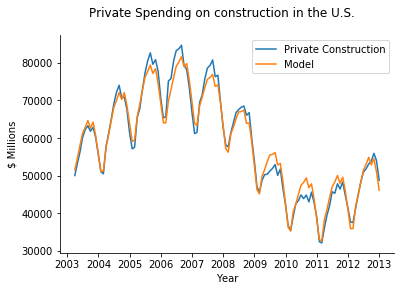

In [11]:
df_private['fit'] = df_private['MovAvg'] + df_private['C']
fig,ax = plt.subplots()
ax.plot(df_private['PrivateConstruction'],label='Private Construction')
ax.plot(df_private['fit'], label = 'Model')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle('Private Spending on construction in the U.S.')
ax.legend()

# Public spending on construction (time series decomposition)

In [12]:
df_public = df_cons[['Month', 'Month-Year', 'PublicConstruction']].copy()
df_public

,Month,Month-Year,PublicConstruction
0,1,2-Jan,14243
1,2,2-Feb,14113
2,3,2-Mar,14386
3,4,2-Apr,16221
4,5,2-May,18375
...,...,...,...
141,142,13-Oct,25823
142,143,13-Nov,22741
143,144,13-Dec,19369
144,145,14-Jan,16834


Based on the initial visualization of the public construction data seen below, the trend of the data appears to be nonlinear.

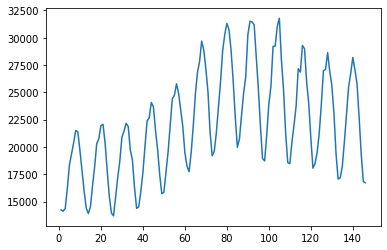

In [13]:
plt.plot(df_public.Month, df_public.PublicConstruction)

#### Similar to the private construction data, a moving average was used to calculate the 'trend' component of this model. Window sizes of 2, 4, 6, 8, and 10 months resulted in a lower average of squared errors, followed by 30 months in this case. 30 months was chosen so that cyclicality could account for the rest of the residual data.

Average Squared Error per Month:  10162878.733036399
Cumulative Squared Error:  1178893933.0322223


,Month,Month-Year,PublicConstruction,MovAvg,sqErr
2003-04-30,16,3-Apr,16444,17767.850000,1.752579e+06
2003-05-31,17,3-May,18187,18022.050000,2.720850e+04
2003-06-30,18,3-Jun,20301,18281.066667,4.080131e+06
2003-07-31,19,3-Jul,20755,18464.316667,5.247230e+06
2003-08-31,20,3-Aug,21957,18529.966667,1.174456e+07
...,...,...,...,...,...
2012-07-31,127,12-Jul,27104,23777.400000,1.106627e+07
2012-08-31,128,12-Aug,28640,23823.666667,2.319707e+07
2012-09-30,129,12-Sep,26938,23676.516667,1.063727e+07
2012-10-31,130,12-Oct,25632,23379.583333,5.073381e+06


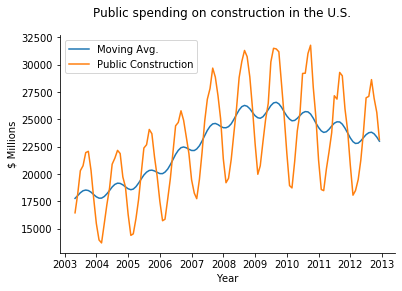

In [14]:
def sqErr(row):
    return (row['PublicConstruction'] - row['MovAvg'])**2

df_public['MovAvg'] = np.NaN
df_public['sqErr'] = np.NaN

# Converts the index of the data frame to a 'time' format
df_public.index = pd.date_range(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_public['PublicConstruction']))

window = 30
window = window - window % 2

# Loop below computes the moving average centered on each of the data points
for i in range(int(window/2),df_public.shape[0]-int(window/2)):
    df_public.loc[df_public.index[i],'MovAvg'] = (0.5*df_public.iloc[i - int(window/2)]['PublicConstruction'] + df_public.iloc[i - int(window/2)+1:i + int(window/2)]['PublicConstruction'].sum() + 0.5*df_public.iloc[i + int(window/2)]['PublicConstruction'])/float(window)

# Calculation of the 'square error' for each data point
df_public['sqErr'] = (df_public['PublicConstruction'] - df_public['MovAvg'])**2

# Drops the rows that cannot be used in the data set (based on the window size)
df_public.dropna(how='any',inplace=True)

# Plots the public construction data with the calculated moving average overlayed
fig,ax = plt.subplots()
ax.plot(df_public['MovAvg'],label='Moving Avg.')
ax.plot(df_public['PublicConstruction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle('Public spending on construction in the U.S.')
ax.legend()
print('Average Squared Error per Month: ',sum(df_public['sqErr'])/len(df_public))
print('Cumulative Squared Error: ', sum(df_public['sqErr']))
df_public

Average Residual:  151.06178160919546


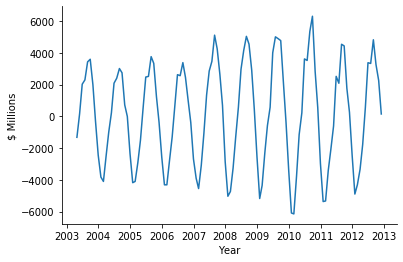

In [15]:
"""Calculating and plotting the residuals, 'R1'."""

df_public['R1'] = df_public['PublicConstruction'] - df_public['MovAvg']
df_public['R1Error'] = abs((df_public['PublicConstruction'] - df_public['R1'])/df_public['PublicConstruction'])
df_public.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

fig,ax = plt.subplots()
ax.plot(df_public['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_public['R1'])/len(df_public))

In [16]:
"""Calculating the autocorrelation from the residual data to determine whether any cyclical patterns exist."""

maxCorr = 0.0
period = np.NaN
for i in range(1,21):
    corr = df_public['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8414240855266022
Correlation, lag  2     0.4825023143375913
Correlation, lag  3     0.0092202921214571
Correlation, lag  4     -0.4736103623569163
Correlation, lag  5     -0.8136390403979123
Correlation, lag  6     -0.9393004514092911
Correlation, lag  7     -0.8228553092490353
Correlation, lag  8     -0.49012818896984267
Correlation, lag  9     -0.017826645324924936
Correlation, lag  10     0.45230654920919505
Correlation, lag  11     0.8220974531489251
Correlation, lag  12     0.9732672393898196
Correlation, lag  13     0.8252050545241905
Correlation, lag  14     0.4796571507321633
Correlation, lag  15     0.011172348202403386
Correlation, lag  16     -0.46443189762294884
Correlation, lag  17     -0.8010500481838283
Correlation, lag  18     -0.9305766201889459
Correlation, lag  19     -0.8214379207386715
Correlation, lag  20     -0.4954115643359868
period =  12      Maximum Correlation =  0.9732672393898196


#### Just like the private data, a period of 12 is the maximium correlation for the public data, suggesting that the cyclicality component is for 12 months or one year. The graph below plots the data in 12 month inverals, and the red line is the average of all the cycles.

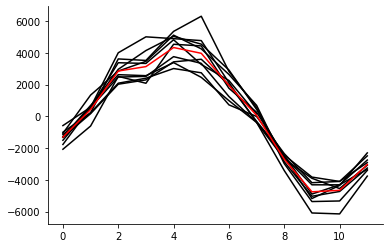

In [17]:
period = 12
cycleLen = period
numCycles = int(len(df_public)/cycleLen + 0.5)
cycles = [df_public.iloc[range(i*period,min((i+1)*period,len(df_public)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df_public.iloc[range(i,len(df_public['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### The cyclicality component is calculated and plotted against the residual data to visualize how close of a fit it is.

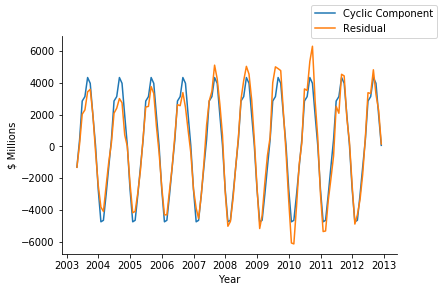

In [18]:
cycleLen = period
numCycles = int(len(df_public)/cycleLen + 0.5)
df_public['C'] = np.NaN
for i in range(len(df_public)):
    df_public.loc[df_public.index[i], 'C'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(df_public['C'],label='Cyclic Component')
ax.plot(df_public['R1'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

#### The error of the model compared to the original data series is calculated ('R2Public'), as well as the error relative to the original data series ('R2ErrorPublic'). The overall average error is computed as well.

In [19]:
df_public['R2Public'] = df_public['R1'] - df_public['C']
df_public['R2ErrorPublic'] = abs(df_public['R2Public']/df_public['PublicConstruction'])
df_public.drop(['R1', 'R1Error'],axis=1,inplace=True)
print('Average Error: ', sum(df_public['R2ErrorPublic'])/len(df_public))
df_public

Average Error:  0.02306334109301478


,Month,Month-Year,PublicConstruction,MovAvg,sqErr,C,R2Public,R2ErrorPublic
2003-04-30,16,3-Apr,16444,17767.850000,1.752579e+06,-1310.048333,-13.801667,0.000839
2003-05-31,17,3-May,18187,18022.050000,2.720850e+04,426.836667,-261.886667,0.014400
2003-06-30,18,3-Jun,20301,18281.066667,4.080131e+06,2849.081667,-829.148333,0.040843
2003-07-31,19,3-Jul,20755,18464.316667,5.247230e+06,3127.465000,-836.781667,0.040317
2003-08-31,20,3-Aug,21957,18529.966667,1.174456e+07,4328.583333,-901.550000,0.041060
...,...,...,...,...,...,...,...,...
2012-07-31,127,12-Jul,27104,23777.400000,1.106627e+07,3127.465000,199.135000,0.007347
2012-08-31,128,12-Aug,28640,23823.666667,2.319707e+07,4328.583333,487.750000,0.017030
2012-09-30,129,12-Sep,26938,23676.516667,1.063727e+07,3964.943333,-703.460000,0.026114
2012-10-31,130,12-Oct,25632,23379.583333,5.073381e+06,1943.613333,308.803333,0.012048


#### The final model is combined together below ('fit'). The graph plots the original data series versus the model.

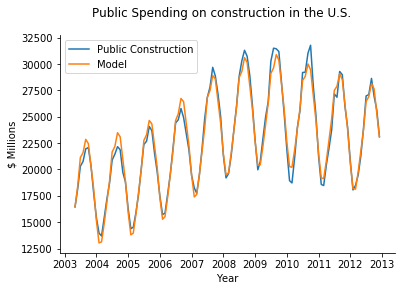

In [21]:
df_public['fit'] = df_public['MovAvg'] + df_public['C']
fig,ax = plt.subplots()
ax.plot(df_public['PublicConstruction'],label='Public Construction')
ax.plot(df_public['fit'], label = 'Model')
ax.set_xlabel('Year')
ax.set_ylabel('$ Millions')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle('Public Spending on construction in the U.S.')
ax.legend()